# Analysis


In [1]:
import os, glob
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read input data

In [11]:
def script_read_multiruns():
    IN_PARENT_DIR = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-21/19-51-45'
    Prog_File_wc = '*/train_incremental.log'  # or progress.csv???? TODO fiture this out
    Config_File_wc = '*/.hydra/config.yaml'
    
    PD_DF_SEP = '\|'
    
    
    def get_progress_file_dict_key(path_str):
        """Helper method to get dict key for both the progress files
        and the config files"""
        return path_str.split('/')[-2]
    
    def get_config_file_dict_key(path_str):
        return path_str.split('/')[-3]
        
    mr_dict = {}
    
    prog_file_path_list = glob.glob(os.path.join(IN_PARENT_DIR, Prog_File_wc))
    for path in prog_file_path_list:
        d_k = get_progress_file_dict_key(path)
        mr_dict[d_k] = {
            'df': pd.read_csv(path, sep=PD_DF_SEP)
        }
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Config_File_wc)):
        d_k = get_config_file_dict_key(path)
        mr_dict[d_k]['config'] = yaml.load(open(path))
    
    return mr_dict
        
        

DataDict = script_read_multiruns()
len(DataDict)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


6

#### Get all attributes into columns and concate all runs

In [38]:
import collections

def construct_data_df(runs_dict):    
    def recursive_helper(configDict, curStr='', headerDict={}):
        """Helper to extract all the nested attributes into a
        single attribute dict"""
        # Base case: no child dictionaries
        if not isinstance(configDict, collections.Mapping):
            headerDict[curStr] = str(configDict)
            return None
        
        # Recursion
        for k in configDict:
            if len(curStr) == 0:
                childStr = k
            else:
                childStr = f'{curStr}.{k}'
            recursive_helper(configDict[k], childStr, headerDict)
        return None
    
    # ==
    # Add configs to dataframes and concat
    all_df_list = []
    
    for run_k in runs_dict:
        cur_run_dict = runs_dict[run_k]
        
        # Extract header
        config_dict = {}
        recursive_helper(cur_run_dict['config'], 
                         curStr='', 
                         headerDict=config_dict)
        
        
        # Add to dataframe
        cur_df = cur_run_dict['df'].copy(deep=True)
        for header_k in config_dict:
            col_val = config_dict[header_k]
            cur_df[header_k] = [col_val] * len(cur_df)
            
        
        all_df_list.append(cur_df)
        
    # ==
    # Concat and output
    all_concat_df = pd.concat(all_df_list)
    all_concat_df = all_concat_df.reset_index()
    
    return all_concat_df


Data_df = construct_data_df(DataDict)

# NOTE: fixing a bug here since we are getting the non progress.csv logs
def script_fix_messy_epis_str(messy_col_str, df):
    messy_str_list = df[messy_col_str].values
    clean_list = []
    for e in messy_str_list:
        cur_ele = None
        if isinstance(e, str):
            cur_ele = e.split(' ')[-1]
        clean_list.append(cur_ele)
    df['episode_count'] = clean_list
    return df

print(len(Data_df))
Data_df[0:3]

1692


,index,"[2021-01-21 19:51:54,015][Experiment][INFO] - episode_count",total_steps,episode_return,exp_average_return,value_loss,reward_loss,sf_loss,lsf_v_v_diff,et_loss,...,algo.kwargs.min_denom,algo.kwargs.sf_lambda,model.cls_string,model.kwargs.fc_sizes,model.kwargs.sf_hidden_sizes,"[2021-01-21 20:43:38,180][Experiment][INFO] - episode_count","[2021-01-21 23:19:11,898][Experiment][INFO] - episode_count","[2021-01-21 22:27:14,418][Experiment][INFO] - episode_count","[2021-01-21 21:35:24,684][Experiment][INFO] - episode_count","[2021-01-22 00:12:31,220][Experiment][INFO] - episode_count"
0,0,"[2021-01-21 19:52:01,382][Experiment][INFO] - 100",1152,0.54,0.352960,0.054138,0.015374,0.001339,0.014015,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN
1,1,"[2021-01-21 19:52:08,154][Experiment][INFO] - 200",2224,0.46,0.416029,0.055071,0.011698,0.000005,0.016079,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN
2,2,"[2021-01-21 19:52:15,432][Experiment][INFO] - 300",3372,0.54,0.496920,0.056504,0.013186,0.000007,0.016827,None,...,0.0001,0.3,LSF_ACNetwork,128,None,NaN,NaN,NaN,NaN,NaN


In [39]:
print(Data_df.columns.values.tolist())

['index', '[2021-01-21 19:51:54,015][Experiment][INFO] - episode_count', 'total_steps', 'episode_return', 'exp_average_return', 'value_loss', 'reward_loss', 'sf_loss', 'lsf_v_v_diff', 'et_loss', 'training.seed', 'runner.n_steps', 'runner.kwargs.log_interval_episodes', 'runner.kwargs.log_dir_path', 'env.kwargs.env_name', 'algo.cls_string', 'algo.kwargs.discount_gamma', 'algo.kwargs.lr_alpha', 'algo.kwargs.trace_lambda', 'algo.kwargs.entropy_beta', 'algo.kwargs.grad_rms_gamma', 'algo.kwargs.grad_rms_eps', 'algo.kwargs.min_denom', 'algo.kwargs.sf_lambda', 'model.cls_string', 'model.kwargs.fc_sizes', 'model.kwargs.sf_hidden_sizes', '[2021-01-21 20:43:38,180][Experiment][INFO] - episode_count', '[2021-01-21 23:19:11,898][Experiment][INFO] - episode_count', '[2021-01-21 22:27:14,418][Experiment][INFO] - episode_count', '[2021-01-21 21:35:24,684][Experiment][INFO] - episode_count', '[2021-01-22 00:12:31,220][Experiment][INFO] - episode_count']


## Explatory Plots

In [40]:
set(Data_df['algo.cls_string'].values)

{'LSF_ACLambda'}

In [41]:
set(Data_df['algo.kwargs.trace_lambda'].values)

{'0.0'}

In [42]:
set(Data_df['algo.kwargs.sf_lambda'].values)

{'0.3', '0.7', '1.0'}

In [43]:
set(Data_df['model.kwargs.sf_hidden_sizes'].values)

{'None'}

In [44]:
set(Data_df['training.seed'].values)

{'2', '4'}

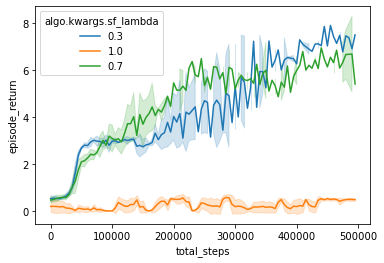

In [52]:
def round_2_int(value, nearest=10):
    try:
        rounded = int(value / nearest) * nearest
    except ValueError:
        rounded = np.nan
    return rounded
        
def simple_lineplot(x, y, data, sns_kwargs={},
                    round_x=None, round_y=None,
                    filters=None):    
    df = data.copy(deep=True)
    # In case non numeric
    df[x] = pd.to_numeric(df[x], errors='coerce')
    df[y] = pd.to_numeric(df[y], errors='coerce')
    # if roudning
    if round_x is not None:
        df[x] = [round_2_int(v, round_x) for v in df[x].values]
    if round_y is not None:
        df[y] = [round_2_int(v, round_y) for v in df[y].values]

    
    if filters is not None:
        for f_k in filters:
            df = df[df[f_k] == filters[f_k]]
    
    sns.lineplot(x=x, y=y,
                 data=df, **sns_kwargs)

simple_lineplot(
    x='total_steps', y='episode_return', 
    round_x=5e3,
    data=Data_df,
    sns_kwargs={'hue': 'algo.kwargs.sf_lambda', 
                'ci': 'sd'},
)

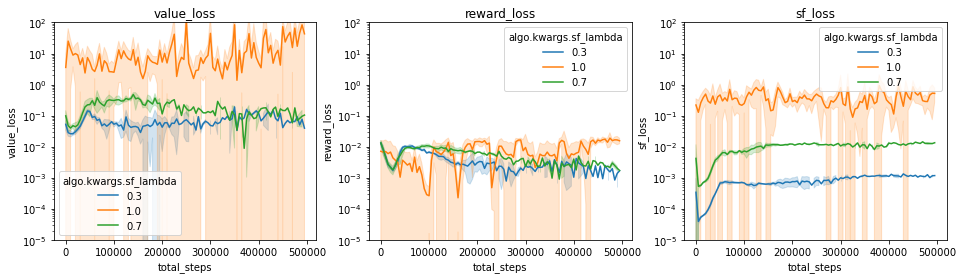

In [81]:
def script_subplot_losses(in_df):
    plt_hue = 'algo.kwargs.sf_lambda'
    y_list = [
        'value_loss', 'reward_loss', 'sf_loss'
    ]
    
    plt.figure(figsize=(16,4))
    
    for i, cur_y in enumerate(y_list):
        plt.subplot(1,len(y_list), (i+1))
        
        simple_lineplot(
            x='total_steps', y=cur_y,
            round_x=5e3,
            data=Data_df,
            sns_kwargs={'hue': plt_hue,
                        'ci': 'sd'},
        )
        
        
        plt.title(cur_y)
        plt.ylim([1e-5, 100])
        plt.yscale('log')
        
script_subplot_losses(Data_df)

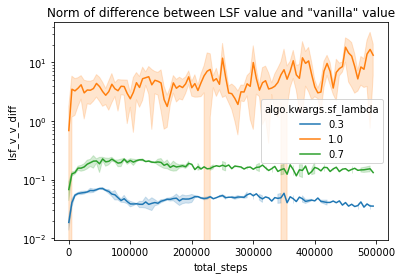

In [85]:
simple_lineplot(
    x='total_steps', y='lsf_v_v_diff',
    round_x=5e3,
    data=Data_df,
    sns_kwargs={'hue': 'algo.kwargs.sf_lambda',
                'ci': 'sd'},
)
plt.title('Norm of difference between LSF value and "vanilla" value')
plt.yscale('log')


## Compare with AC(lambda)

In [57]:
def ac_script_read_multiruns():
    IN_PARENT_DIR = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-21/07-14-12'
    Prog_File_wc = '*/progress.csv'
    Config_File_wc = '*/.hydra/config.yaml'
    
    PD_DF_SEP = '\|'
    
    
    def get_progress_file_dict_key(path_str):
        """Helper method to get dict key for both the progress files
        and the config files"""
        return path_str.split('/')[-2]
    
    def get_config_file_dict_key(path_str):
        return path_str.split('/')[-3]
        
    mr_dict = {}
    
    prog_file_path_list = glob.glob(os.path.join(IN_PARENT_DIR, Prog_File_wc))
    for path in prog_file_path_list:
        d_k = get_progress_file_dict_key(path)
        mr_dict[d_k] = {
            'df': pd.read_csv(path, sep=PD_DF_SEP)
        }
    
    for path in glob.glob(os.path.join(IN_PARENT_DIR, Config_File_wc)):
        d_k = get_config_file_dict_key(path)
        mr_dict[d_k]['config'] = yaml.load(open(path))
    
    return mr_dict
        
        
aclamb_DataDict = ac_script_read_multiruns ()
print(len(aclamb_DataDict))

aclamb_Data_df = construct_data_df(aclamb_DataDict)
print(len(aclamb_Data_df))
aclamb_Data_df[0:3]

4
1820


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


,index,"2021-01-21 07:14:22,231",Unnamed: 1,episode_count,total_steps,episode_return,exp_average_return,value_loss,reward_loss,sf_loss,...,algo.kwargs.trace_lambda,algo.kwargs.entropy_beta,algo.kwargs.grad_rms_gamma,algo.kwargs.grad_rms_eps,algo.kwargs.min_denom,model.cls_string,model.kwargs.fc_sizes,"2021-01-21 08:26:46,020","2021-01-21 10:58:00,678","2021-01-21 09:42:00,742"
0,0,"2021-01-21 07:14:27,242",NaN,100,1066,0.46,0.2747868150737452,0.04362880483900699,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN
1,1,"2021-01-21 07:14:32,227",NaN,200,2148,0.47,0.3779216160590847,0.03936976974864948,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN
2,2,"2021-01-21 07:14:37,045",NaN,300,3172,0.42,0.4045995241326716,0.033605155723305746,None,None,...,0.0,0.01,0.999,0.0001,0.0001,ACNetwork,128,NaN,NaN,NaN


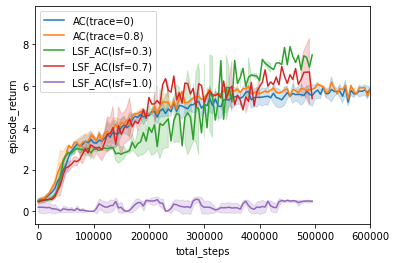

In [80]:
def script_plot_ac_lsf_together(in_ac_df, in_lsf_df):
    round_nearest = 5e3
    plt_y = 'episode_return'
    
    ac_df = in_ac_df.copy(deep=True)
    lsf_df = in_lsf_df.copy(deep=True)
    
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=ac_df,
        sns_kwargs={'ci': 'sd'},
        filters={'algo.kwargs.trace_lambda': '0.0'}
    )
    
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=ac_df,
        sns_kwargs={'ci': 'sd'},
        filters={'algo.kwargs.trace_lambda': '0.8'}
    )
    
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=lsf_df,
        sns_kwargs={'ci': 'sd'},
        filters={'algo.kwargs.sf_lambda': '0.3'}
    )
    
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=lsf_df,
        sns_kwargs={'ci': 'sd'},
        filters={'algo.kwargs.sf_lambda': '0.7'}
    )
    
    simple_lineplot(
        x='total_steps', y='episode_return', 
        round_x=5e3,
        data=lsf_df,
        sns_kwargs={'ci': 'sd'},
        filters={'algo.kwargs.sf_lambda': '1.0'}
    )
    
    plt.xlim([-5e3, 6e5])
    plt.legend(['AC(trace=0)', 'AC(trace=0.8)', 
                'LSF_AC(lsf=0.3)', 'LSF_AC(lsf=0.7)', 'LSF_AC(lsf=1.0)'])
    
    
script_plot_ac_lsf_together(aclamb_Data_df, Data_df)